# Using https://youtu.be/u1loyDCoGbE for implementation of U-net : https://arxiv.org/pdf/1505.04597.pdf

In [208]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import cv2 as cv
import time

In [3]:
# #Google Collab specifics
# from google.colab import drive
# drive.mount('/content/drive')
# !cp "/content/drive/MyDrive/helpers.py" .
# imgs_names = glob.glob( '/content/drive/MyDrive/th_analysedimages/*.tif')
# labels_names = glob.glob('/content/drive/MyDrive/labels/*.png')

In [8]:
#Local github project specifics
imgs_names = glob.glob( './th_analysedimages/*.tif')
labels_names = glob.glob('./th_csv_labels/png_masks_emb/*.png')

In [16]:
imgs_names= sorted(imgs_names)
#imgs = [cv.imread(name, cv.IMREAD_UNCHANGED) for name in imgs_names[1]]
print(f"Found {len(imgs_names)} images")

labels_names= sorted(labels_names)
#labels = [png_to_mask(cv.imread(name, cv.IMREAD_UNCHANGED)) for name in labels_names]
print(f"Found {len(labels_names)} labels")

Found 357 images
Found 357 labels


<img src="./U-Net structure.png" width="500">

In [271]:
# UNet definitions
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # functions for going down the U
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.d_double_conv_1 = double_conv(1, 64)
        self.d_double_conv_2 = double_conv(64, 128)
        self.d_double_conv_3 = double_conv(128, 256)
        self.d_double_conv_4 = double_conv(256, 512)
        self.d_double_conv_5 = double_conv(512, 1024)
        
        # functions for going up the U
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)        
        self.u_double_conv_4 = double_conv(1024, 512)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.u_double_conv_3 = double_conv(512, 256)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.u_double_conv_2 = double_conv(256, 128)
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.u_double_conv_1 = double_conv(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, image):
        '''makes the 388x388 prediction with the model, image must be 572x572pixels'''
        
        # Going down the U
        d1 = self.d_double_conv_1(image) # first "level"
        # print(x1.size())
        x = self.max_pool_2x2(d1)
        d2 = self.d_double_conv_2(x) # second
        x = self.max_pool_2x2(d2)
        d3 = self.d_double_conv_3(x) # third
        x = self.max_pool_2x2(d3)
        d4 = self.d_double_conv_4(x) # fourth
        x = self.max_pool_2x2(d4)
        x = self.d_double_conv_5(x) # last layer (fifth) : no max pool
        # plt.imshow(x.detach().numpy()[0, 0, :, :])
        
        # Going up the U
        x = self.up_trans_4(x)
        d4 = crop_img(tensor=d4, target_tensor=x) #crop to copy
        x = self.u_double_conv_4(torch.cat([d4, x], 1))
        
        x = self.up_trans_3(x)
        d3 = crop_img(tensor=d3, target_tensor=x)
        x = self.u_double_conv_3(torch.cat([d3, x], 1))
        
        x = self.up_trans_2(x)
        d2 = crop_img(tensor=d2, target_tensor=x)
        x = self.u_double_conv_2(torch.cat([d2, x], 1))
        
        x = self.up_trans_1(x)
        d1 = crop_img(tensor=d1, target_tensor=x)
        x = self.u_double_conv_1(torch.cat([d1, x], 1))
        
        x = self.out(x)
        x = self.sigmoid(x)
        return x
        
        
    
# some functions so reduce redunduncy
def double_conv(nb_in_channels, nb_out_channels):
    conv = nn.Sequential(
        nn.Conv2d(nb_in_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(nb_out_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
    )
    return conv

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2] # NB they are square so .size[2]=.size[3]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size #target is always smaller
    pix_crop = delta // 2
    return tensor[:, :, pix_crop:tensor_size-pix_crop, pix_crop:tensor_size-pix_crop]

torch.FloatTensor
Output shape : (1, 1, 388, 388)
Output max value : 0.4961341321468353, min=0.49054408073425293


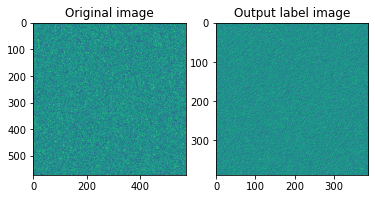

In [272]:
# Test forward to see how it behaves
image = torch.rand((1, 1, 572, 572))
print(image.type())
model = UNet()
y = model(image).detach().numpy()
print(f"Output shape : {y.shape}")
print(f"Output max value : {y[0,0, :, :].max()}, min={y[0,0, :, :].min()}")
_ , axs = plt.subplots(ncols=2)
axs[0].imshow(image.detach().numpy()[0,0,:,:])
axs[0].set_title("Original image")
axs[1].imshow(y[0,0, :, :])
axs[1].set_title("Output label image")
plt.show()

In [289]:
# Training function
from helpers import png_to_mask, segment_dataset

def train_model(model, img_pathnames, label_pathnames, criterion, optimizer, device, num_epochs=25):
    
    print("Starting the training on images !")
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        
        for image_i in range(len(img_pathnames)):
            image = cv.imread(img_pathnames[image_i], cv.IMREAD_UNCHANGED)
            label = png_to_mask(cv.imread(label_pathnames[image_i], cv.IMREAD_UNCHANGED))
                        
            image_segments, label_segments = segment_dataset([image], [label])
            
            for segment_i in range(len(image_segments[:, 0, 0])):
                since = time.process_time()
                img_seg = torch.tensor(image_segments[segment_i, :, :], requires_grad=True).view(1, 1, 572, 572).to(device).float()
                label_seg = torch.tensor(label_segments[segment_i, :, :].astype(float), requires_grad=True).view(1, 1, 388, 388).to(device).float()
#                 if image_i<1 and epoch<1:
#                     print(img_seg.size())
#                     print(label_seg.size())
#                     _ , axs = plt.subplots(ncols=2)
#                     axs[0].imshow(img_seg.detach().numpy()[0,0,:,:])
#                     axs[0].set_title("Segment of original image")
#                     axs[1].imshow(label_seg.detach().numpy()[0,0,:,:])
#                     axs[1].set_title("Segment of original label")
#                     plt.show()
                
                prediction = model(img_seg)
                loss = criterion(label_seg, prediction.detach() )
            
                # Compute the gradient
                optimizer.zero_grad()
                loss.backward()

                # Update the parameters of the model with a gradient step
                optimizer.step()
            
                time_elapsed = time.process_time()-since
                print(f"loss={loss} segment train time={int(time_elapsed)//60}m {int(time_elapsed%60)}s")
                print(f"After step taken, loss was reduced by {loss-criterion(label_seg, model(img_seg).detach())}")
                                

In [290]:
# If a GPU is available (ex when on Google Colab)
if not torch.cuda.is_available():
    print("Things will go much quicker if you enable a GPU, ex in Colab under 'Runtime / Change Runtime Type'")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"    Selected device is: {device}/n")
    
learning_rate = 0.01
model = UNet().to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_model(model, imgs_names[:10], labels_names[:10], criterion, optimizer, device)

Things will go much quicker if you enable a GPU, ex in Colab under 'Runtime / Change Runtime Type'
    Selected device is: cpu/n
Starting the training on images !
Epoch 0/24
loss=97.31603240966797 segment train time=0m 6s
After step taken, loss was reduced by 0.0


KeyboardInterrupt: 